In [ ]:
"""
1- Model İncelemesi:
    print(model) komutuyla BERT mimarisinin katman yapısı incelenmiştir (attention ve feed-forward katmanları).

2- Attention Ağırlıklarının Görselleştirilmesi:
    Basit bir cümle ("The cat sat on the mat.") modele verilerek, modelin self-attention ağırlıkları çıkarılmış ve 
    heatmap ile hangi kelimelerin birbirine ne düzeyde dikkat ettiği görselleştirilmiştir. 
    Bu, modelin cümledeki kelimeler arası ilişkileri nasıl algıladığını anlamak için kullanılmıştır.

3- Token Embedding PCA Görselleştirmesi:

    BERT’in son katmanından alınan token embedding’leri PCA ile iki boyuta indirgenmiş ve görselleştirilmiştir. 
    Bu sayede, kelimelerin modelin embedding uzayında birbirlerine ne kadar yakın temsil edildiği (anlamsal ilişkileri) analiz edilmiştir.
"""

In [8]:
from transformers import BertTokenizer, BertModel
import torch

# Model and tokenizer 
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_attentions=True)

# Inspect the Model
print(model)


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [2]:
# Create a sample text
sentence = "The cat sat on the mat."

#  tokenize and tensor
inputs = tokenizer(sentence, return_tensors="pt")


In [3]:
# Modeli çalıştır (output_attentions=True olmalı)
outputs = model(**inputs)

# Attention çıktısı: (num_layers, batch_size, num_heads, seq_len, seq_len)
attentions = outputs.attentions


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


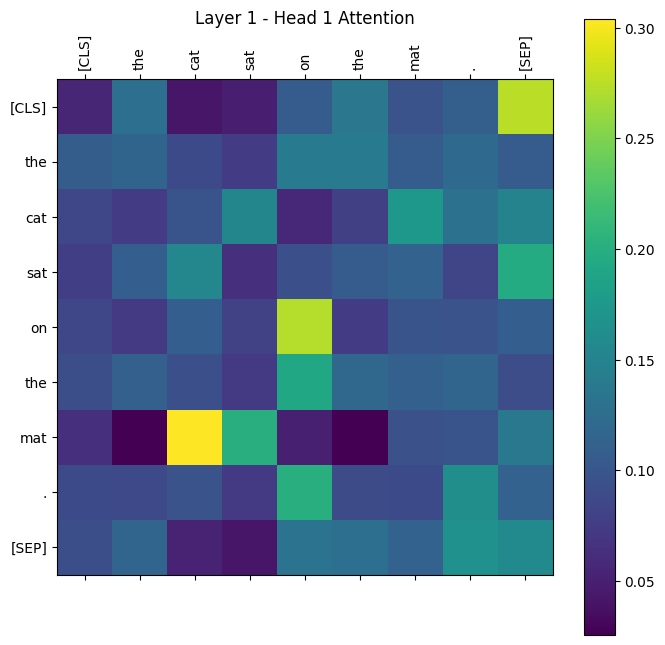

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# İlk layer, ilk head'in attention matrisini al
layer = 0
head = 0
attention = attentions[layer][0, head].detach().numpy()

# Tokenları al
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Görselleştir
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(attention, cmap="viridis")

ax.set_xticks(range(len(tokens)))
ax.set_yticks(range(len(tokens)))

ax.set_xticklabels(tokens, rotation=90)
ax.set_yticklabels(tokens)

plt.colorbar(cax)
plt.title(f"Layer {layer+1} - Head {head+1} Attention")
plt.show()


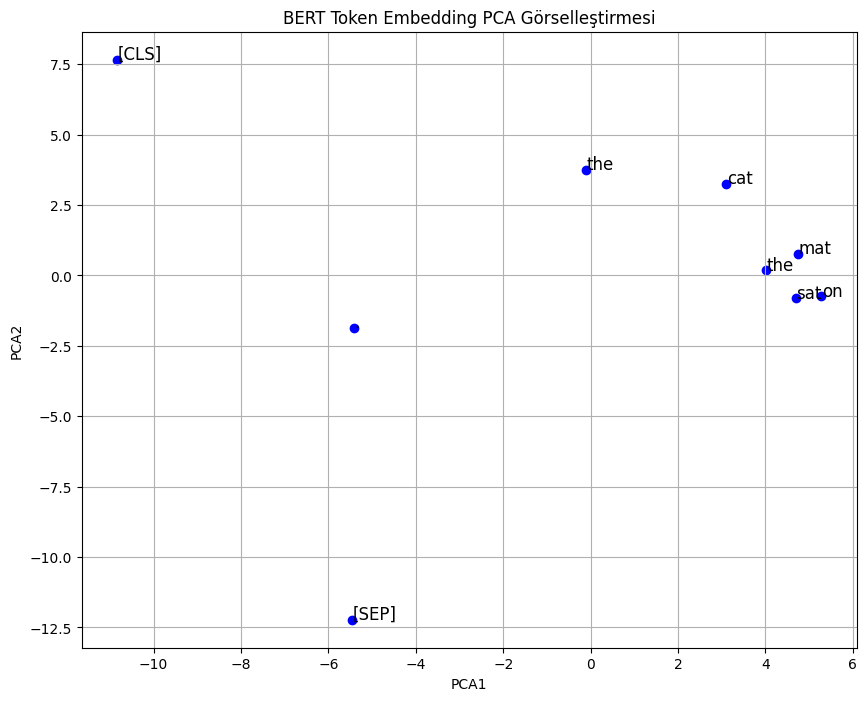

In [ ]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Token embeddinglerini al (batch_size=1 olduğu için 0. örneği alıyoruz)
token_embeddings = outputs.last_hidden_state[0]  # shape: (seq_len, hidden_dim)

# Tokenları al
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# PCA ile 2 boyuta indir
pca = PCA(n_components=2)
reduced = pca.fit_transform(token_embeddings.detach().numpy())

# Görselleştir
plt.figure(figsize=(10, 8))
for i, token in enumerate(tokens):
    x, y = reduced[i]
    plt.scatter(x, y, color='blue')
    plt.text(x + 0.01, y + 0.01, token, fontsize=12)

plt.title("BERT Token Embedding PCA Görselleştirmesi")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.grid(True)
plt.show()
